In [12]:
import sys,os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy import stats
import scipy.special
from matplotlib import rc, rcParams
import math
from scipy.integrate import simps
import copy as cp
%matplotlib inline 
%pylab inline
import pmx
from pmx import rosetta
from pmx.utils import create_folder
from pmx import library

Populating the interactive namespace from numpy and matplotlib


In [13]:
_one_letter = {
    'ALA':'A', 'ARG':'R', 'ASN':'N', 'ASP':'D', 'ASPP':'D', 'ASPH':'D', 
    'CYS':'C', 'CYS2':'C', 'CYN':'C', 'CYX':'C', 'CYM':'C', 'GLU':'E', 
    'GLUP':'E', 'GLN':'Q', 'GLY':'G', 'HIS':'H', 'HIE':'H', 'HSE':'H', 
    'HIP':'H', 'HSP':'H', 'HID':'H', 'HSD':'H', 'ILE':'I', 'LEU':'L', 
    'LYS':'K', 'LSN':'K', 'LYSH':'K', 'LYP':'K', 'MET':'M', 'PHE':'F', 
    'PRO':'P', 'SER':'S', 'THR':'T', 'TRP':'W', 'TYR':'Y', 'VAL':'V', 
    'NALA':'A', 'NGLY':'G', 'NSER':'S', 'NTHR':'T', 'NLEU':'L', 'NILE':'I', 
    'NVAL':'V', 'NASN':'N', 'NGLN':'Q', 'NARG':'R', 'NHID':'H', 'NHIE':'H', 
    'NHIP':'H', 'NTRP':'W', 'NPHE':'F', 'NTYR':'Y', 'NGLU':'E', 'NASP':'D', 
    'NLYP':'K', 'NPRO':'P', 'NCYN':'C', 'NCYX':'C', 'NMET':'M', 'CALA':'A', 
    'CGLY':'G', 'CSER':'S', 'CTHR':'T', 'CLEU':'L', 'CILE':'I', 'CVAL':'V', 
    'CASN':'N', 'CGLN':'Q', 'CARG':'R', 'CHID':'H', 'CHIE':'H', 'CHIP':'H', 
    'CTRP':'W', 'CPHE':'F', 'CTYR':'Y', 'CGLU':'E', 'CASP':'D', 'CLYP':'K', 
    'CPRO':'P', 'CCYN':'C', 'CCYX':'C', 'CMET':'M', 'ZN':'ZN' }


def read_data(fname,pdb=None):
    fp = open(fname,'r')
    lines = fp.readlines()
    fp.close()
    res_ddg = {}
    res_err = {}
    for l in lines:
        l = l.rstrip()
        foo = l.split(' | ')
        bar = foo[-1].split()
        ddg = float(bar[0])
        err = float(bar[1])
        
        bar = foo[0].split('_')
        chain = bar[1][-1]
        mut = bar[2]
        resi = int(mut[0:-1])
        wt = pdb.fetch_residue(idx=resi, chain=chain).resname
        wt = _one_letter[wt]
        
        res_ddg[chain+'_'+wt+mut] = ddg
        res_err[chain+'_'+wt+mut] = err

    return(res_ddg,res_err)


def read_data_alchemy(fname,pdb=None):
    fp = open(fname,'r')
    lines = fp.readlines()
    fp.close()
    res_ddg = {}
    res_err = {}
    for l in lines:
        if l.startswith('#'):
            continue
        
        l = l.rstrip()
        foo = l.split()
        
        ddg = float(foo[1])
        err = float(foo[2]) # foo[2] is error from bootstrap, foo[3] error from independent replicas
        
        bar = foo[0].split('_')
        chain = bar[1][-1]
        mut = bar[2]
        resi = int(mut[0:-1])
        wt = pdb.fetch_residue(idx=resi, chain=chain).resname
        wt = _one_letter[wt]        
        
        res_ddg[chain+'_'+wt+mut] = ddg
        res_err[chain+'_'+wt+mut] = err

    return(res_ddg,res_err)
      
# sorting functions
def sort_all( data ):
    sorted_data = {}
    for key, value in sorted(data.items(), key=lambda item: item[1]):
        sorted_data[key] = value    
    return(sorted_data)

def get_best_per_position( ddg ):
    out = {}
    foo = {} # store positions
    for key in ddg.keys():
        pos = key[0:-1]
        if pos in foo.keys():
            if ddg[key]<foo[pos][0]:
                foo[pos] = [ddg[key],key]
        else:
            foo[pos] = [ddg[key],key]
            
    for key in foo.keys():
        out[foo[key][1]] = foo[key][0]
            
    return(out)
            
def plot_sorted( ddg, err, lessThan=999.99, bLabel=False, maxTotal=99999, bestPerPosition=False,
               minColorVal=None, maxColorVal=None, position=None, colorBy=None, colorByErr=None, fig=None,
               keys=None, colorbarLabel='stability'):
    
    ddg = sort_all( ddg )
    if bestPerPosition==True:
        ddg = get_best_per_position( ddg )
#        print(ddg)

    if keys==None:
        keys = ddg.keys()
    else: # the trick below is for sorting
        foo = {}
        for key in keys:
            foo[key] = ddg[key]
        ddg = sort_all( foo )
        keys = ddg.keys()
    
    #### get min max
    minval = 999.99
    maxval = -999.99
    n = 0
    for key in keys:
        val = ddg[key]
        if position!=None and position not in key:
            continue
        if val<minval:
            minval = val
        if val>maxval:
            maxval = val
        if val<lessThan:
            n+=1
    if lessThan<999.99:
        maxval=0.0
        
    keys = list(keys)
    firstKeys = []
    lastKeys = []
    if maxTotal<99999 and maxTotal<float(n)/2.0:
        firstKeys = keys[0:int(maxTotal/2.0)]
        lastKeys = keys[-int(maxTotal/2.0):-1]
        keys = firstKeys+lastKeys
        n = len(keys)+3
    
    
    #### plot
    cm = plt.get_cmap('bwr')    
    i = 0
    bDone=False
    delta = maxval-minval
    if minColorVal!=None and maxColorVal!=None:
        delta = maxColorVal-minColorVal
        
    ### coloring by provided value
    if colorBy!=None:
        #### get min max for color
        minvalColor = 999.99
        maxvalColor = -999.99
        for key in keys:
            val = colorBy[key]
            if position!=None and position not in key:
                continue
            if val<minvalColor:
                minvalColor = val
            if val>maxvalColor:
                maxvalColor = val
        delta = maxvalColor-minvalColor
        if minColorVal!=None and maxColorVal!=None:
            delta = maxColorVal-minColorVal    
        else:
            minColorVal = minvalColor
            maxColorVal = maxvalColor
    ### coloring by provided value        
        
    size = 19600*1.0/float(n)
    x = []
    xLabel = []
    for key in keys:
        if ddg[key]>lessThan:
            break
            
        if len(firstKeys)>0 and i>=len(firstKeys) and bDone==False:
            plt.scatter(i,0.,marker='x',edgecolor='black',color='k',lw=0.5,s=size,zorder=3)
            plt.scatter(i+1,0.,marker='x',edgecolor='black',color='k',lw=0.5,s=size,zorder=3)
            plt.scatter(i+2,0.,marker='x',edgecolor='black',color='k',lw=0.5,s=size,zorder=3)            
            i+=3
            bDone=True
        
        color = np.abs(ddg[key]-minval)/delta
        if minColorVal!=None:
            if ddg[key]<minColorVal:
                color=0.0
            else:
                color = np.abs(ddg[key]-minColorVal)/delta
        ### coloring by provided value
        if colorBy!=None:
            color = np.abs(colorBy[key]-minColorVal)/delta
        ### coloring by provided value
            

        if position!=None and position not in key:
            continue
            
        plt.scatter(i,ddg[key],marker='o',edgecolor='black',color=cm(color),lw=0.5,s=size,zorder=3)
        # add a significance sign
        if colorBy!=None and colorByErr!=None:
            # check significance
            if np.abs(colorBy[key])-1.96*colorByErr[key]>0.0:
                plt.scatter(i,ddg[key],marker='*',edgecolor='black',color='k',lw=0.5,s=size*0.3,zorder=3)
            
        plt.errorbar(i,ddg[key],yerr=err[key],
                     fmt='none',ecolor='k',zorder=2,mew=1.25, capsize=4, elinewidth=1.5)
        x.append(i)
        xLabel.append(key)
        i += 1
    
    plt.xlim(-.5,i+0.25)
    plt.ylim(minval-0.5,maxval+0.5)
    plt.gca().set_ylabel(r'$\Delta\Delta$G, kcal/mol',fontsize=26)    

    xkcal = [-.5,i+0.25]
    ykcal1 = [-1,-1]
    ykcal2 = [1,1]
    plt.fill_between(xkcal,ykcal1,ykcal2,color='gray',alpha=0.5,zorder=1)

    xx = [-.5,i+0.25]
    plt.plot(xx,[0,0], '--',color='black',alpha=0.35,linewidth=3.0)
    
    #ax = plt.gca()
    ax1.set_axisbelow(True)
    ax1.spines['right'].set_color('none')
    ax1.spines['top'].set_color('none')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.yaxis.set_ticks_position('left')
    ax1.tick_params(axis='x', labelsize=24)
    ax1.tick_params(axis='y', labelsize=24)
    
    if bLabel==True:
        fsize = 12
        if n<50:
            fsize = 22
        plt.xticks(x,xLabel, rotation=90,fontsize=fsize)
    else:
        ax1.xaxis.set_ticklabels([])

    ### colorbar    
    if colorBy!=None and fig!=None:
        cax = fig.add_axes([1.001, 0.05, 0.02, 0.9])
        norm = mpl.colors.Normalize(vmin=minColorVal, vmax=maxColorVal)
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cm, norm=norm, orientation='vertical')
        string = r'$\Delta\Delta$G'+'$_{'+colorbarLabel+'}$'+', kcal/mol'
        cb.ax.set_ylabel(string, fontsize = 26, rotation=-90, labelpad=26)
        #cb.ax.set_ylabel(r'$\Delta\Delta$G$_{}$, kcal/mol', fontsize = 26, rotation=-90, labelpad=26)
        cb.ax.tick_params(labelsize=22)          
        

def write_pml( ddg, fname, inPDB, outPDB, minColor=None, maxColor=None ):
    outPDBname = outPDB.split('/')[-1]
    
    ddg = get_best_per_position( ddg )

    ###### minval/maxval #######
    
    ###### color #######
    #delta = maxval-minval
    #if minColorVal!=None and maxColorVal!=None:
    #    delta = maxColorVal-minColorVal      
    
    ###### get entries by position ######
    positions = {}
    for key in ddg.keys():
        foo = key.split('_')
        chain = foo[0]
        resnum = foo[1][1:-1]
        positions[key[0:-1]] = [ddg[key],chain,resnum]
        #print(positions[key[0:-1]])
    
    ####### fill B-factors ######
    ##### and write pml ####
    fp = open(fname,'w')
    fp.write('delete all\n')
    fp.write('load {0}\n'.format(outPDBname))
    fp.write('bg white\n')
    fp.write('show cartoon\n')
    fp.write('hide lines\n')
    
    m = pmx.Model(inPDB,renumber_residues=False,bPDBTER=True,rename_atoms=False)
    counter = 0
    mutatedChains = []
    for r in m.residues:
        wt = _one_letter[r.resname]          
        key = r.chain_id+'_'+wt+str(r.id)
        
        if key in positions.keys():
            if r.chain_id not in mutatedChains:
                mutatedChains.append(r.chain_id)
            fp.write('select mut{0}, chain {1} and resi {2}\n'.format(counter,r.chain_id,r.id))            
            counter+=1            
            for a in r.atoms:
                a.bfac = positions[key][0]
        else:
            for a in r.atoms:
                a.bfac = 0.0
    m.write(outPDB)
    
    fp.write('show sticks, mut*\n')
    fp.write('select nonMutated, all and not mut*\n')
    if minColor!=None and maxColor!=None:
        fp.write('spectrum b, blue_white_red, minimum={0}, maximum={1}\n'.format(minColor,maxColor))
    else:
        fp.write('spectrum b, blue_white_red\n')        
    fp.write('color gray20, nonMutated\n')
    mcString = 'chain'
    i = 0
    for mc in mutatedChains:
        if i==0:
            mcString = mcString+' '+mc
        else:
            mcString = mcString+'+'+mc
        i+=1
    fp.write('select chainsMut, {0} and nonMutated\n'.format(mcString))
    fp.write('color gray70, chainsMut\n')
    fp.write('set ray_opaque_background, off\n')
    fp.write('set ray_trace_mode, 1\n')
    fp.write('deselect\n')
    fp.close()        

-------------------
6m0j virusMutations ROSETTA
----------------------

In [14]:
###### variables, parameters #######
workfolder = './rosetta_flex_ddg/'

#refchain = 'E' # chain with respect to which the interface will be identifiedb

In [15]:
# read structure, based on which the WT residues will be assigned
wtpdb = pmx.Model('./prot_zn.pdb', renumber_residues=False)

In [7]:
# read
ddg,err = read_data( workfolder+'/mutations/results.dat', pdb=wtpdb )

# sort all
#sorted_ddg = sort_all( ddg )
# sort for every chain
# best for every position

In [8]:
################ collect and output potential mutations #################
def get_entry( key, val ):
    foo = key.split('_')
    chain = foo[0]
    num = foo[1][0:-1]
    mut = foo[1][-1]
    entry = "{0} {1} {2} {3}\n".format(chain, num, mut, val)
    return(entry)

def is_in_keys( keys, subkey ):
    p = re.compile('A_\D'+subkey)
    for key in keys:
        if p.match(key)!=None:
            return(key)
    return(False)

ddgsorted = sort_all( ddg )
count = 0
used = []
fp = open('rosetta_virusMutations.dat','w')

# best per position
out = get_best_per_position( ddgsorted )
for key in out.keys():
    if key in used:
        continue
    entry = get_entry(key,out[key])
    fp.write(entry)
    count+=1
    used.append(key)
    
# 5 best in pos 41
i = 0
for key in ddgsorted.keys():
    if (i<5) and ('A_Y41' in key) and (key not in used):
        entry = get_entry(key,ddgsorted[key])
        fp.write(entry)
        count+=1
        i+=1
        used.append(key)

# 5 best in pos 27
i = 0
for key in ddgsorted.keys():
    if (i<5) and ('A_T27' in key) and (key not in used):
        entry = get_entry(key,ddgsorted[key])
        fp.write(entry)
        count+=1
        i+=1
        used.append(key)
        
# ala scan
for i in range(0,1000):
    key = str(i)+'A'
    key = is_in_keys( ddgsorted.keys(),key )
    if (key!=False) and (key not in used):
        entry = get_entry(key,ddgsorted[key])
        fp.write(entry)
        count+=1
        used.append(key)

# < -0.5 kcal/mol
for key in ddgsorted.keys():
    if (ddgsorted[key]<-0.5) and (key not in used):
        entry = get_entry(key,ddgsorted[key])
        fp.write(entry)
        count+=1
        used.append(key)

print('In total: {0} mutations'.format(count))
    
fp.close()

In total: 10 mutations


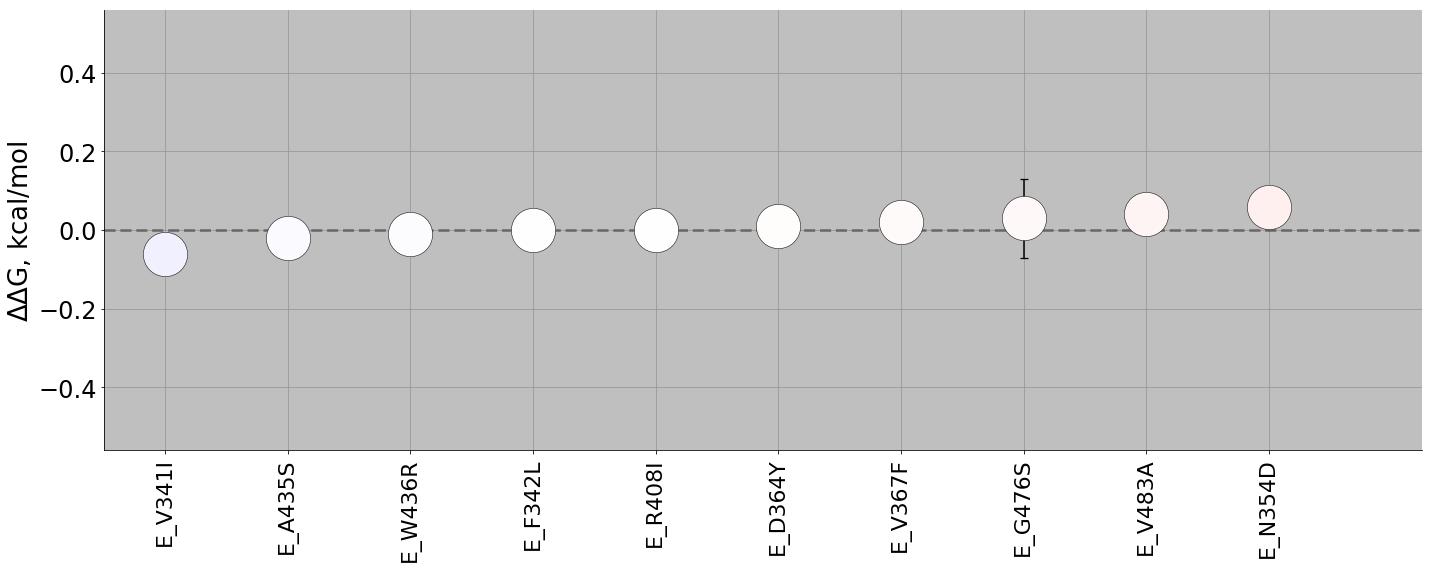

In [31]:
##### plot all #####
figure(1,figsize=(20, 8))
rc('text', usetex=False)

################  ##################
################  ##################
ax1 = subplot(111)


#plt.gca().set_xlabel(r'',fontsize=26)

grid(True,alpha=1.0)
cm = plt.get_cmap('bwr')

plot_sorted( ddg, err, bLabel=True,minColorVal=-1, maxColorVal=1)



plt.tight_layout(w_pad=0.5)
#plt.savefig('rosetta_virusMutations.png',dpi=200,transparent=True,bbox_inches='tight')
plt.show()

In [24]:
## pml ##
    
#write_pml(ddg, 'structure_figures/pml_helix.pml', 
#         inPDB='./prot_zn.pdb',
 #        outPDB='structure_figures/ddG_helix.pdb',minColor=-2,maxColor=2)    

-------------------
6m0j_helix ALCHEMY
----------------------

In [9]:
# read
ddg_alchemy,err_alchemy = read_data_alchemy('/netmount/energy/vgapsys/covid19/ipython/alchemy_results_virusMutations/ddg.dat',pdb=wtpdb )
apo_alchemy,apo_err_alchemy = read_data_alchemy('/netmount/energy/vgapsys/covid19/ipython/alchemy_results_virusMutations/stability_apo.dat',pdb=wtpdb )
complex_alchemy,complex_err_alchemy = read_data_alchemy('/netmount/energy/vgapsys/covid19/ipython/alchemy_results_virusMutations/stability_complex.dat',pdb=wtpdb )

In [11]:
for key in apo_alchemy.keys():
    print(key,apo_alchemy[key],err_alchemy[key],ddg[key])

E_V341I -1.71 0.1 -0.06
E_F342L -0.05 0.16 -0.0
E_N354D -1.32 0.26 0.06
E_D364Y -1.41 0.84 0.01
E_V367F -1.53 0.15 0.02
E_R408I -1.03 0.29 0.0
E_A435S 1.32 0.1 -0.02
E_W436R 1.99 0.7 -0.01
E_G476S 0.11 0.14 0.03
E_V483A 1.67 0.07 0.04


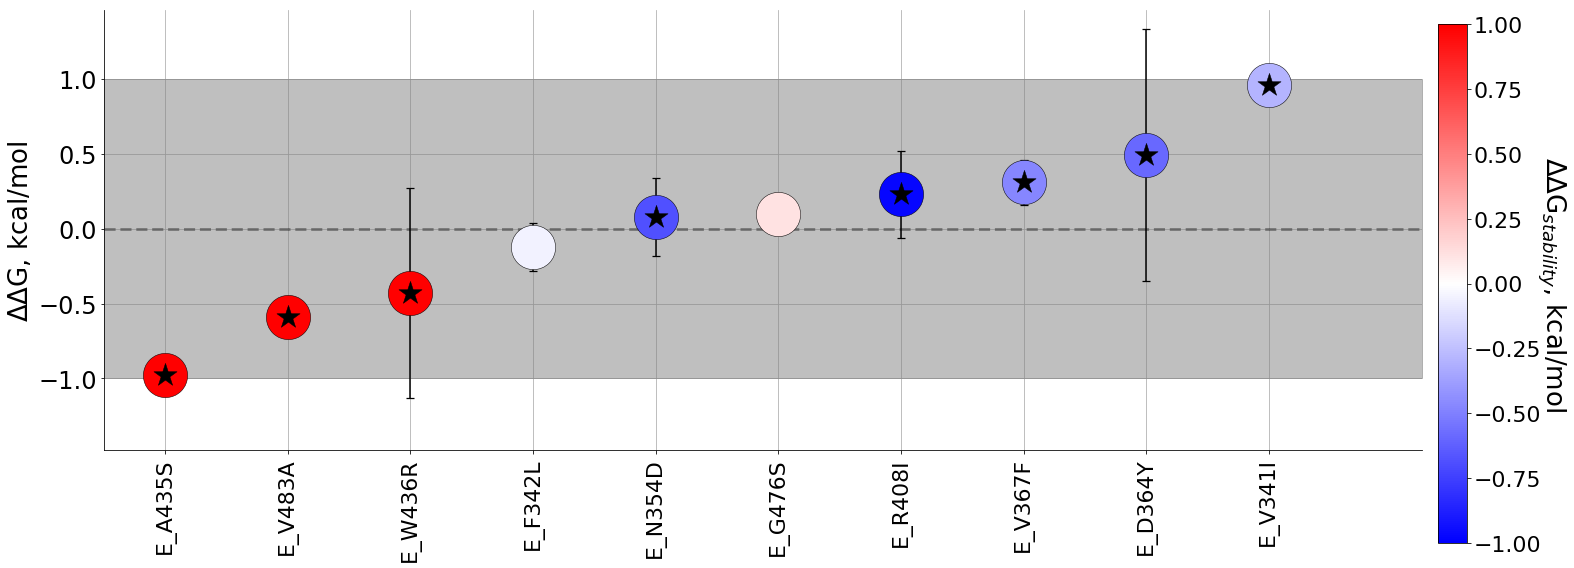

In [28]:
##### plot the best for each position #####
fig = figure(1,figsize=(20, 8))
rc('text', usetex=False)

################  ##################
################  ##################
ax1 = subplot(111)


#plt.gca().set_xlabel(r'',fontsize=26)

grid(True,alpha=1.0)
cm = plt.get_cmap('bwr')

plot_sorted( ddg_alchemy, err_alchemy, bestPerPosition=True, bLabel=True,minColorVal=-1, maxColorVal=1,
            colorBy=apo_alchemy, colorByErr=apo_err_alchemy, fig=fig)



plt.tight_layout(w_pad=0.5)
plt.savefig('figures/alchemy_virusMutations.png',dpi=200,transparent=True,bbox_inches='tight')
plt.show()

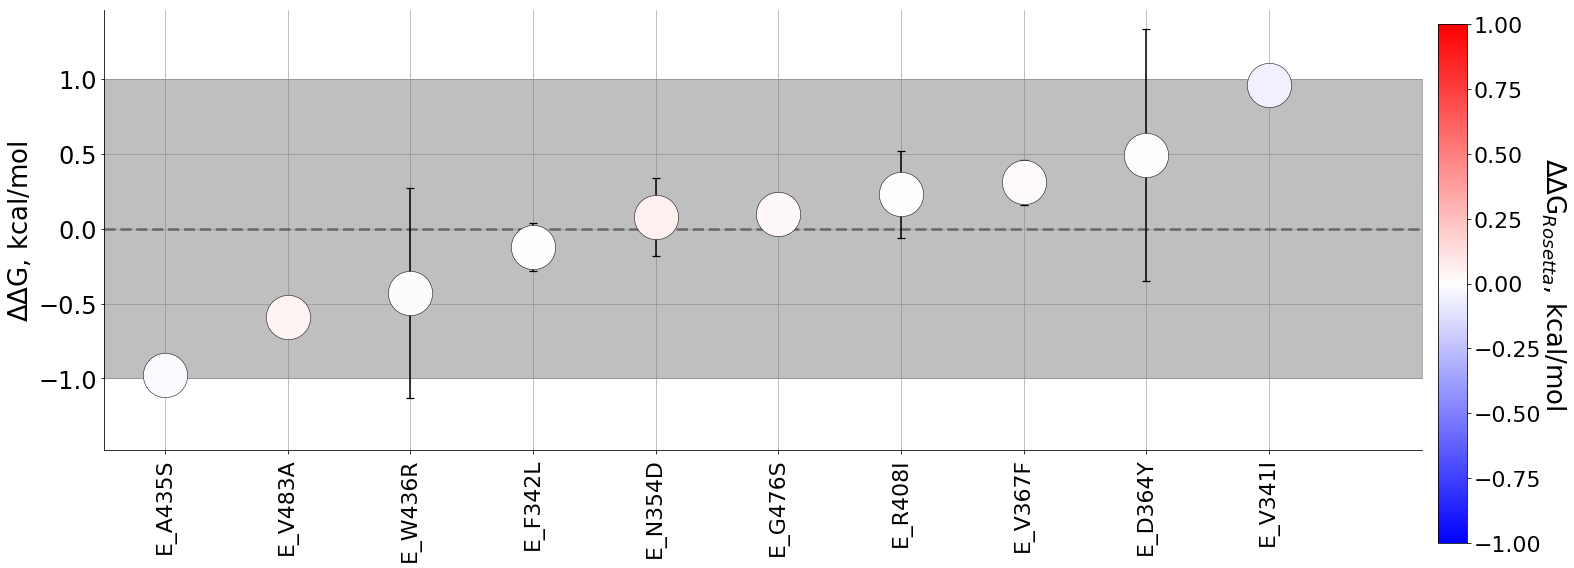

In [27]:
##### plot all below -0.0 kcal/mol #####
# color by rosetta
fig = figure(1,figsize=(20, 8))
rc('text', usetex=False)

################  ##################
################  ##################
ax1 = subplot(111)


#plt.gca().set_xlabel(r'',fontsize=26)

grid(True,alpha=1.0)
cm = plt.get_cmap('bwr')

plot_sorted( ddg_alchemy,err_alchemy, bLabel=True,minColorVal=-1, maxColorVal=1,
            colorBy=ddg,  fig=fig, colorbarLabel='Rosetta')

plt.tight_layout(w_pad=0.5)
#plt.savefig('figures/alchemy_colorRosetta_helix_stabilizing_more_0kcal.png',dpi=200,transparent=True,bbox_inches='tight')
plt.show()

In [25]:
#write_pml(ddg_alchemy, 'structure_figures/pml_alchemy_helix.pml', inPDB='/netmount/energy/vgapsys/covid19/pdb_6m0j/prot_helix.pdb',
#         outPDB='structure_figures/ddG_alchemy_helix.pdb',minColor=-2,maxColor=2)    

In [35]:
# colored by ddg alchemy
write_pml(ddg_alchemy, 'structure_figures/pml_alchemy_virusMutations.pml', inPDB='/netmount/energy/vgapsys/covid19/pdb_6m0j/prot_zn.pdb',
         outPDB='structure_figures/ddG_alchemy_virusMutations.pdb',minColor=-1,maxColor=1)       

In [38]:
# colored by apo alchemy stability
write_pml(apo_alchemy, 'structure_figures/pml_alchemy_stability_virusMutations.pml', inPDB='/netmount/energy/vgapsys/covid19/pdb_6m0j/prot_zn.pdb',
         outPDB='structure_figures/ddG_alchemy_virusMutations.pdb',minColor=-1,maxColor=1)       

In [39]:
apo_alchemy

{'E_V341I': -1.71,
 'E_F342L': -0.05,
 'E_N354D': -1.32,
 'E_D364Y': -1.41,
 'E_V367F': -1.53,
 'E_R408I': -1.03,
 'E_A435S': 1.32,
 'E_W436R': 1.99,
 'E_G476S': 0.11,
 'E_V483A': 1.67}